In [1]:
import numpy as np
from matplotlib import pyplot as plt

from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional, ExternalPotential
from dftpy.formats import io
from dftpy.math_utils import ecut2nr
from dftpy.optimization import Optimization


from ase.build import bulk
from ase.io.trajectory import Trajectory
from ase.io import read
from ase.lattice.spacegroup import Spacegroup
from ase.lattice.spacegroup import crystal

from scipy.optimize import minimize

/home/vr371/.local/lib/python3.8/site-packages/ase/lattice/spacegroup.py:5: UserWarning: Moved to ase.spacegroup
  warnings.warn('Moved to ase.spacegroup')


In [2]:
from sklearn.model_selection import train_test_split 
from sklearn.kernel_ridge import KernelRidge #as modelKR
from sklearn.linear_model import Ridge #as modelR
from sklearn.linear_model import Lasso
from dscribe.descriptors import CoulombMatrix, SineMatrix, EwaldSumMatrix, SOAP
from sklearn.tree import DecisionTreeRegressor

In [3]:
def get_energy(Phase, KEDF, a, b):
    dictionary = {
        'Si_Btin': {'structure': 'diamond', 'pp': 'si.lda.recpot'}, 
        'Si_fcc': {'structure': 'fcc', 'lattice': '3.405'},
        'Si_bcc': {'structure': 'bcc', 'lattice': '3.09'},
        'Si_8cd': {'structure': 'diamond', 'lattice': '5.43'},
        'Si_7cd': {'structure': 'diamond', 'lattice': '5.43'},
    }
    
    path_pp='/home/vr371/PP/ofpp/EAC/upf/blps/'
    file1='si.lda.upf'
    PP_list = {'Si': path_pp+file1}
    
    KS_TE = []
    for i in np.arange(0,30,1):
        with open('/home/vr371/cWT-KEDF/Phases/DATA/'+ str(Phase)+ '/DATA2/Si'+str(i)+'.out') as D:
            k = [match for match in D if "Total energy" in match]
        KS_te = str(k).split()[6]
        KS_TE.append(float(KS_te))

    VOLUME = []
    l = np.linspace(0.8, 1.4, 30)
    for i, d in enumerate(l):
        if Phase == 'Si_Btin':
            ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        else:
            ions = Ions.from_ase(bulk('Si', dictionary[Phase]['structure'], a=float(dictionary[Phase]['lattice']), cubic=True))
        if Phase == 'Si_7cd':
            ions.pop(i=1)
        cell = ions.get_cell()
        ions.set_cell(cell * d, scale_atoms=True)
        vol=ions.get_volume()
        VOLUME.append(vol)
    
    r = np.linspace(0.8, 1.4, 30)
    KE = Functional(type='KEDF',name=KEDF, lumpfactor=[a,b])
    XC = Functional(type='XC',name='LDA')
    HARTREE = Functional(type='HARTREE')
    energy, VOLUME = [], []
    for i, d in enumerate(r):
        if Phase == 'Si_Btin':
            ions = Ions.from_ase(crystal('Si',[(0,0,0)],spacegroup=141,cellpar = [4.81,4.81,2.65, 90,90,90]))
        else:
            ions = Ions.from_ase(bulk('Si', dictionary[Phase]['structure'], a=float(dictionary[Phase]['lattice']), cubic=True))
        if Phase == 'Si_7cd':
            ions.pop(i=1)
        cell = ions.get_cell()
        ions.set_charges(4)
        ions.set_cell(cell * l[i], scale_atoms=True)
        nr = ecut2nr(ecut=50, lattice=ions.cell)
        grid = DirectGrid(lattice=ions.cell, nr=nr)
        rho_ini = DirectField(grid=grid)
        rho_ini[:] = ions.get_ncharges()/ions.cell.volume
        PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list, rcut=10)
        realevaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
        optimization_options = {'econv' : 1e-5*ions.nat}
        optreal = Optimization(EnergyEvaluator=realevaluator, optimization_options = optimization_options, 
                           optimization_method = 'TN')
        realrho = optreal.optimize_rho(guess_rho=rho_ini)
        realenergy = realevaluator.Energy(rho=realrho, ions=ions)
        vol = ions.get_volume()
        energy.append(realenergy)
        VOLUME.append(vol)
  
    return np.asarray(KS_TE), np.asarray(energy), np.asarray(VOLUME)

In [4]:
KS_TE, energy, VOLUME = get_energy('Si_Btin', 'MGP', a=0.6,b=0.8)

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.810500545993E+00      9.810501E+00    4.864018E+00    1       1       1.683826E+00    
1       8.884579098812E+00      -9.259214E-01   3.820655E-01    3       1       1.720789E+00    
2       8.842506833167E+00      -4.207227E-02   1.620076E-02    8       1       1.779593E+00    
3       8.841556802074E+00      -9.500311E-04   1.275178E-03    8       1       1.828822E+00    
4       8.841462741910E+00      -9.406016E-05   7.525801E-05    10      1       1.879457E+00    
5       8.841459517179E+00      -3.224731E-06   6.603575E-06    6       1       1.910625E+00    
6       8.841458873533E+00      -6.436458E-07   4.541475E-07    10      1       1.957385E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.7786803395574736
Chemical potential (eV)  : 21.18896928747443
setting key: Si -> /home/vr37

3       4.083881983622E+00      -1.252786E-03   1.518168E-03    8       1       2.528327E-01    
4       4.083799771854E+00      -8.221177E-05   1.082855E-04    9       1       3.415594E-01    
5       4.083792013427E+00      -7.758427E-06   7.597004E-06    11      1       4.427116E-01    
6       4.083791697647E+00      -3.157796E-07   6.677914E-07    6       1       5.041187E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.3967710358223245
Chemical potential (eV)  : 10.796688788850723
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       4.556389029367E+00      4.556389E+00    2.801720E+00    1       1       1.223898E-02    
1       3.651528840638E+00      -9.048602E-01   1.948122E-01    11      2       1.213636E-01    
2       3.643584546520E+00      -7.944294E-03   1.187248E-02    6       1       1.976540E-01    
3       3.642656004394E+00  

Chemical potential (a.u.): 0.17981806511975376
Chemical potential (eV)  : 4.893098317238707
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.273920846138E+00      2.273921E+00    2.332492E+00    1       1       2.280357E+00    
1       9.476983605803E-01      -1.326222E+00   5.828174E-01    12      2       2.477058E+00    
2       9.229590590140E-01      -2.473930E-02   5.311467E-02    6       1       2.579919E+00    
3       9.181547364011E-01      -4.804323E-03   4.964866E-03    11      1       2.754810E+00    
4       9.179062063474E-01      -2.485301E-04   3.788720E-04    7       1       2.875654E+00    
5       9.178698472753E-01      -3.635907E-05   2.657646E-05    12      1       3.058673E+00    
6       9.178687388149E-01      -1.108460E-06   1.887175E-06    7       1       3.175192E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0

6       -7.738931997515E-01     -1.070995E-05   8.702269E-06    11      1       4.312054E+00    
7       -7.738939785115E-01     -7.787600E-07   7.717977E-07    8       1       4.475634E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.05496382000271387
Chemical potential (eV)  : 1.4956415807565369
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.949408264520E-01      9.949408E-01    2.174495E+00    1       1       2.476978E-02    
1       1.929520219830E-01      -8.019888E-01   4.847258E+00    16      2       3.158240E-01    
2       -9.912831082506E-01     -1.184235E+00   3.023237E-01    13      2       5.598879E-01    
3       -1.001539048899E+00     -1.025594E-02   2.837220E-02    4       1       6.535616E-01    
4       -1.005344789664E+00     -3.805741E-03   1.226762E-03    13      2       9.043450E-01    
5       -1.005448483890E+00

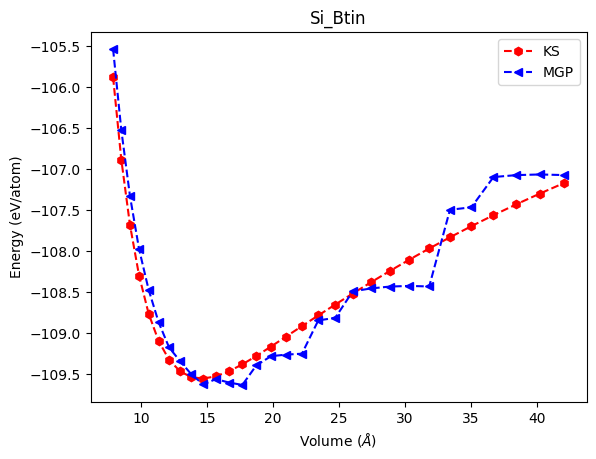

In [5]:
plt.plot(np.asarray(VOLUME)*0.529177**3/4, np.asarray(KS_TE)*27.21138/8,'rh--',label='WT')
plt.plot(np.asarray(VOLUME)*0.529177**3/4, np.asarray(energy)*27.21138/4,'b<--',label='CR')
plt.xlabel('Volume ($\AA$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si_Btin')
plt.legend(['KS','MGP'])

In [12]:
KS_TE, energy, VOLUME = get_energy('Si_8cd', 'MGP', a=0.341,b=0.45)

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.438148381693E+01      1.438148E+01    9.442635E+00    1       1       1.821282E+00    
1       1.113909272152E+01      -3.242391E+00   5.692958E-01    13      2       2.090539E+00    
2       1.111359654052E+01      -2.549618E-02   5.532030E-02    5       1       2.177566E+00    
3       1.111029238354E+01      -3.304157E-03   4.182685E-03    7       1       2.289428E+00    
4       1.110999848066E+01      -2.939029E-04   3.260954E-04    9       1       2.424184E+00    
5       1.110998662016E+01      -1.186050E-05   2.729088E-05    5       1       2.505162E+00    
6       1.110998380708E+01      -2.813087E-06   8.008306E-07    10      1       2.651141E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.5452970686277465
Chemical potential (eV)  : 14.838287616545564
setting key: Si -> /home/vr3

1       3.018635654411E+00      -3.844560E+00   2.211025E+00    12      2       2.998562E+00    
2       2.960636404621E+00      -5.799925E-02   1.922987E-01    4       1       3.092165E+00    
3       2.951218423793E+00      -9.417981E-03   1.770699E-02    6       1       3.226214E+00    
4       2.949706341187E+00      -1.512083E-03   6.782063E-04    10      1       3.421933E+00    
5       2.949683183222E+00      -2.315796E-05   6.636238E-05    4       1       3.516993E+00    
6       2.949676358368E+00      -6.824854E-06   5.537414E-06    8       2       3.702528E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.24977019348891247
Chemical potential (eV)  : 6.796592503890342
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.245632050754E+00      6.245632E+00    7.245804E+00    1       1       2.595544E-02    
1       2.267609697223E+00  

2       -2.062330448306E+00     -4.148243E-01   4.023616E-01    6       1       5.278392E-01    
3       -2.089956702987E+00     -2.762625E-02   2.951482E-02    8       1       7.472498E-01    
4       -2.094087660838E+00     -4.130958E-03   3.706076E-03    13      1       1.051755E+00    
5       -2.094229906978E+00     -1.422461E-04   3.042447E-04    5       1       1.200470E+00    
6       -2.094253658039E+00     -2.375106E-05   1.478851E-05    8       1       1.412987E+00    
7       -2.094256353945E+00     -2.695907E-06   1.332613E-06    12      1       1.697478E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.08552517231335459
Chemical potential (eV)  : 2.3272582565568585
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.739826537458E+00      2.739827E+00    6.425325E+00    1       1       5.122957E+00    
1       -2.046686948883E+00

6       -5.282002563982E+00     -1.641479E-04   3.332278E-04    12      1       8.675392E+00    
7       -5.282048100027E+00     -4.553605E-05   9.203803E-05    13      1       9.128841E+00    
8       -5.282070876059E+00     -2.277603E-05   8.543460E-06    24      2       9.912487E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.00305301776315281
Chemical potential (eV)  : -0.08307683696537459
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       9.848765732984E-01      9.848766E-01    5.914302E+00    1       1       5.335116E-02    
1       -2.488065930566E+00     -3.472943E+00   4.700768E+01    12      4       5.726123E-01    
2       -5.539322852008E+00     -3.051257E+00   4.138820E+00    11      1       9.672577E-01    
3       -5.689124724924E+00     -1.498019E-01   3.610537E-01    5       1       1.186537E+00    
4       -5.704890467272E

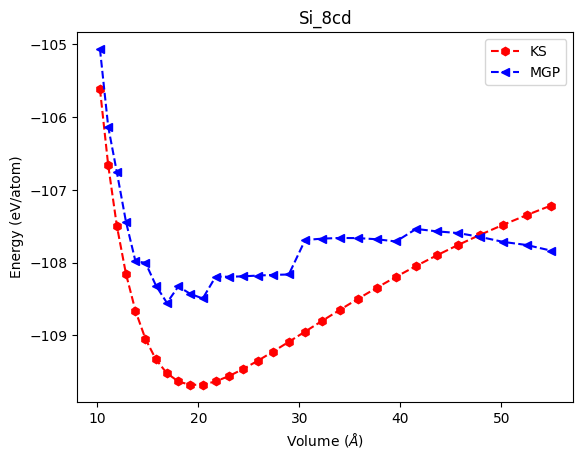

In [13]:
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(KS_TE)*27.21138/16,'rh--',label='WT')
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(energy)*27.21138/8,'b<--',label='CR')
plt.xlabel('Volume ($\AA$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si_8cd')
plt.legend(['KS','MGP'])

In [15]:
KS_TE, energy, VOLUME = get_energy('Si_8cd', 'MGP', a=0.6,b=0.8)

setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       1.438148381693E+01      1.438148E+01    9.442635E+00    1       1       1.579335E+00    
1       1.111265723237E+01      -3.268827E+00   5.781816E-01    13      2       1.781948E+00    
2       1.108688423024E+01      -2.577300E-02   5.502090E-02    5       1       1.866218E+00    
3       1.108359363765E+01      -3.290593E-03   4.169099E-03    7       1       1.981063E+00    
4       1.108329121473E+01      -3.024229E-04   3.410635E-04    9       1       2.121350E+00    
5       1.108327867505E+01      -1.253968E-05   2.858265E-05    5       1       2.208058E+00    
6       1.108327578176E+01      -2.893287E-06   8.547339E-07    10      1       2.358871E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.544230703724067
Chemical potential (eV)  : 14.809270352277474
setting key: Si -> /home/vr37

2       3.085854820103E+00      -5.382178E-02   1.745213E-01    4       1       3.105785E+00    
3       3.077328660286E+00      -8.526160E-03   1.605326E-02    6       1       3.240373E+00    
4       3.075897593741E+00      -1.431067E-03   6.568604E-04    10      1       3.437513E+00    
5       3.075873316662E+00      -2.427708E-05   5.186621E-05    5       1       3.552467E+00    
6       3.075867357552E+00      -5.959109E-06   3.415200E-06    8       1       3.721486E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.2526119641455085
Chemical potential (eV)  : 6.873921014841164
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       6.245632050754E+00      6.245632E+00    7.245804E+00    1       1       2.668953E-02    
1       2.396584831990E+00      -3.849047E+00   2.268896E+00    12      2       2.666004E-01    
2       2.334969732483E+00   

4       -1.827145776697E+00     -3.275024E-03   2.653723E-03    13      1       1.053814E+00    
5       -1.827270854148E+00     -1.250775E-04   2.094559E-04    5       1       1.204997E+00    
6       -1.827294165599E+00     -2.331145E-05   1.879367E-05    10      1       1.456565E+00    
7       -1.827296478714E+00     -2.313115E-06   2.750255E-06    12      1       1.742023E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.09109914115359898
Chemical potential (eV)  : 2.4789336598839773
setting key: Si -> /home/vr371/PP/ofpp/EAC/upf/blps/si.lda.upf
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       2.739826537458E+00      2.739827E+00    6.425325E+00    1       1       5.124978E+00    
1       -1.723796556105E+00     -4.463623E+00   5.189960E+00    12      2       5.521059E+00    
2       -2.052640981328E+00     -3.288444E-01   4.802126E-01    6       1       5.747402E+00    
3       -2.078629486605E+00

0       9.848765732984E-01      9.848766E-01    5.914302E+00    1       1       5.427241E-02    
!WARN : pAp small than zero :iter =  13 -4394763.936645204
1       -3.727079201644E+00     -4.711956E+00   7.368535E+00    14      3       5.939190E-01    
2       -5.058294798629E+00     -1.331216E+00   5.585243E-01    13      1       1.037614E+00    
3       -5.113356052028E+00     -5.506125E-02   5.361101E-02    10      1       1.477733E+00    
4       -5.121750740595E+00     -8.394689E-03   7.272763E-03    14      1       1.964369E+00    
5       -5.122127234310E+00     -3.764937E-04   5.524518E-04    6       1       2.213303E+00    
6       -5.122165633739E+00     -3.839943E-05   2.247420E-05    9       1       2.546022E+00    
7       -5.122170027186E+00     -4.393447E-06   9.273008E-06    12      1       2.966080E+00    
#### Density Optimization Converged ####
Chemical potential (a.u.): -0.002730706249914991
Chemical potential (eV)  : -0.07430629479543005
setting key: Si -> /home/vr

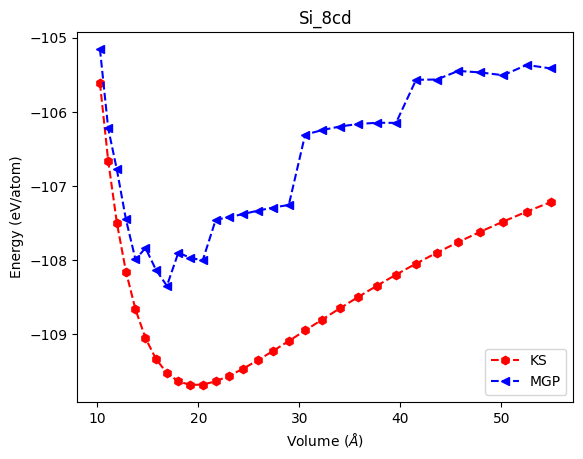

In [16]:
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(KS_TE)*27.21138/16,'rh--',label='WT')
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(energy)*27.21138/8,'b<--',label='CR')
plt.xlabel('Volume ($\AA$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si_8cd')
plt.legend(['KS','MGP'])

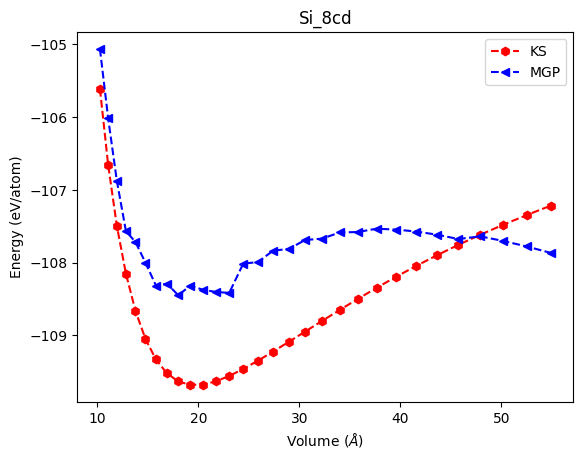

In [45]:
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(KS_TE)*27.21138/16,'rh--',label='WT')
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(energy)*27.21138/8,'b<--',label='CR')
plt.xlabel('Volume ($\AA$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si_8cd')
plt.legend(['KS','MGP'])

In [34]:
KS_TE, energy, VOLUME = get_energy('Si_fcc', 'MGP', a=0.6,b=0.44)

'2.0.0rc2'

In [ ]:
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(KS_TE)*27.21138/16,'rh--',label='WT')
plt.plot(np.asarray(VOLUME)*0.529177**3/8, np.asarray(energy)*27.21138/8,'b<--',label='CR')
plt.xlabel('Volume ($\AA$)')
plt.ylabel('Energy (eV/atom)')
plt.title('Si_fcc')
plt.legend(['KS','MGP'])

In [51]:
import dftpy
print(dftpy.__file__)

/home/vr371/.local/lib/python3.8/site-packages/dftpy/__init__.py
